# NGS pipeline

notebook adapted from this tutorial: https://yezhengstat.github.io/CUTTag_tutorial

# Table Of Contents
* [0. Setup Environment](#setup_env)
* [1. Data](#data)
* [2. Quality Control](#quality_control)
* [3. Alignment](#alignment)
* [4. Reads filtering and file conversion](#post_alignment)
* [5. Spike-in calibration](#spikein)
* [6. Peak Calling](#peak_calling)
* [7. Visualization of peaks](#igv)
* [8. Differential Analysis](#diff_analysis)

# 0. Setup environment <a class="anchor" id="setup_env"> </a>
Note this is not a complete list of steps to get all the prackages.

In [10]:
%load_ext rpy2.ipython  

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [245]:
# set paths here (not done)
ROOT_PATH="/network/projects/_groups/grn_control/bow"
PROGRAMS_FOLDER=f"{ROOT_PATH}/programs"

## Set R <a class="anchor" id="set_r"> </a>

In [ ]:
%%R
install.packages("dplyr")

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
    
BiocManager::install("BiocParallel")

library(BiocParallel)
register(MulticoreParam(8)) # Use 8 cores

install.packages("ggplot2")
install.packages("viridis")
install.packages("ggpubr")
install.packages("gridExtra")
install.packages('xts')
install.packages('quadprog')
install.packages('PerformanceAnalytics')
install.packages("hash")

install.packages("ggrepel")
install.packages("devtools")
install.packages('corrplot')
install.packages("ggpubr")

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GenomicRanges")
BiocManager::install("chromVAR")
BiocManager::install("DESeq2")
BiocManager::install("chromVAR")

In [ ]:
%%bash
conda install -c conda-forge r-nloptr
conda install -c conda-forge r-ggpubr

In [18]:
%%R
library(nloptr)
library(ggpubr)
library(dplyr)
library(stringr)
library(ggplot2)
library(viridis)
library(GenomicRanges)
library(chromVAR) ## For FRiP analysis and differential analysis
library(DESeq2) ## For differential analysis section
library(ggpubr) ## For customizing figures
library(corrplot) ## For correlation plot

## Set Python <a class="anchor" id="set_py"> </a>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame

## Set Bash <a class="anchor" id="set_bash"> </a>

In [ ]:
`prefetch` is from SRA toolkit and serves to donesload data from SRA database 

In [ ]:
java -jar ~/comp-venv/bin/picard.jar -h
conda install -c bioconda bedtools

In [ ]:
%%bash
cd $PROGRAMS_FOLDER && wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
unzip fastqc_v0.11.9.zip
cd fastqcv0.11.9 && ln -s fastqc your-env-path/bin

# 1. Data <a class="anchor" id="data"> </a>

Sample name | SRA
----|----
SH_Hs_K27m3_NX_0918 as replicate 1  | SRR12246717
SH_Hs_K27m3_Xpc_0107 as replicate 2 | SRR11074240
SH_Hs K4m3 NX_0918 as replicate 1   | SRR11074254
SH_Hs_K4m3 Xpc_0107 as replicate 2  | SRR11074258
SH_Hs IgG 1x 0924 as replicate 1    | SRR11923224
SH_Hs IgG 20181224 as replicate 2   | SRR8754611
SH_Hs IgG 20181224 as replicate 2   | SRR8754612

In [318]:
mapping_sra_to_id_name = {
    'SRR12246717' : 'K27me3_rep1',
    'SRR11074240' : 'K27me3_rep2',
    'SRR11074254' : 'K4me3_rep1',
    'SRR11074258' : 'K4me3_rep2',
    'SRR11923224' : 'IgG_rep1',
    'SRR8754612'  : 'IgG_rep2', 
}

## Downloading all samples and split paired reads (w/ prefetch from SRA)

In [77]:
%%bash
data_folder='/network/projects/_groups/grn_control/bow/NanoTag/tutorial/data'
cd $data_folder
pwd
for sra in SRR12246717 SRR11074240 SRR11074254 SRR11074258 SRR11923224 SRR8754612; do
    echo "downloading..."$sra;
    prefetch $sra
    echo "splitting paired reads..."
    fastq-dump --split-3 $sra
done

/network/projects/_groups/grn_control/bow/NanoTag/tutorial/data
downloading...SRR11074240

splitting paired reads...
Read 2702260 spots for SRR11074240
Written 2702260 spots for SRR11074240
downloading...SRR11074254

splitting paired reads...
Read 1581710 spots for SRR11074254
Written 1581710 spots for SRR11074254
downloading...SRR11074258

splitting paired reads...
Read 1885056 spots for SRR11074258
Written 1885056 spots for SRR11074258
downloading...SRR11923224

splitting paired reads...
Read 2127635 spots for SRR11923224
Written 2127635 spots for SRR11923224
downloading...SRR8754611

splitting paired reads...
Read 2192908 spots for SRR8754611
Written 2192908 spots for SRR8754611
downloading...SRR8754612

splitting paired reads...
Read 1168663 spots for SRR8754612
Written 1168663 spots for SRR8754612


2022-11-24T18:27:19 prefetch.3.0.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2022-11-24T18:27:19 prefetch.3.0.1: 1) Downloading 'SRR11074240'...
2022-11-24T18:27:19 prefetch.3.0.1: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2022-11-24T18:27:19 prefetch.3.0.1:  Downloading via HTTPS...
2022-11-24T18:27:21 prefetch.3.0.1:  HTTPS download succeed
2022-11-24T18:27:21 prefetch.3.0.1:  'SRR11074240' is valid
2022-11-24T18:27:21 prefetch.3.0.1: 1) 'SRR11074240' was downloaded successfully
2022-11-24T18:27:21 prefetch.3.0.1: 'SRR11074240' has 0 unresolved dependencies
2022-11-24T18:27:38 prefetch.3.0.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2022-11-24T18:27:38 prefetch.3.0.1: 1) Downloading 'SRR11074254'...
2022-11-24T18:27:38 prefetch.3.0.1: SRA Normalized Format file is being retrieved, if

In [110]:
%%bash 
# optional step
data_folder='/network/projects/_groups/grn_control/bow/NanoTag/tutorial/data'
cd $data_folder
echo "PWD:" `pwd`
for sra in SRR11074240 SRR11074254 SRR11074258 SRR11923224 SRR8754611; do
    mv $sra"_1.fastq" $sra/
    mv $sra"_2.fastq" $sra
done

PWD: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/data
mv SRR11074240_1.fastq to SRR11074240_R1.fastq
mv SRR11074240_2.fastq to SRR11074240/SRR11074240_R1.fastq
mv SRR11074254_1.fastq to SRR11074254_R1.fastq
mv SRR11074254_2.fastq to SRR11074254/SRR11074254_R1.fastq
mv SRR11074258_1.fastq to SRR11074258_R1.fastq
mv SRR11074258_2.fastq to SRR11074258/SRR11074258_R1.fastq
mv SRR11923224_1.fastq to SRR11923224_R1.fastq
mv SRR11923224_2.fastq to SRR11923224/SRR11923224_R1.fastq
mv SRR8754611_1.fastq to SRR8754611_R1.fastq
mv SRR8754611_2.fastq to SRR8754611/SRR8754611_R1.fastq


mv: cannot stat 'SRR11074240_R1.fastq': No such file or directory
mv: cannot stat 'SRR11074254_R1.fastq': No such file or directory
mv: cannot stat 'SRR11074258_R1.fastq': No such file or directory
mv: cannot stat 'SRR11923224_R1.fastq': No such file or directory
mv: cannot stat 'SRR8754611_R1.fastq': No such file or directory


### rename files with their sample id

In [ ]:
data_folder='/network/projects/_groups/grn_control/bow/NanoTag/tutorial/data'
for folder_sample in os.listdir(data_folder):
    
    if folder_sample.startswith('.'):
        continue

    id_name = mapping_sra_to_id_name[folder_sample]
    print(f"renaming file in {folder_sample} as {id_name}")
    
    prefix_file  = f"{data_folder}/{folder_sample}/{folder_sample}"
    
    r1_curr_filepath = f"{prefix_file}_R1.fastq"
    r2_curr_filepath = f"{prefix_file}_R2.fastq"
    
    r1_new_filepath = f"{data_folder}/{folder_sample}/{id_name}_R1.fastq"
    r2_new_filepath = f"{data_folder}/{folder_sample}/{id_name}_R2.fastq"
    
    !echo "mv $r2_curr_filepath $r2_new_filepath"
    !mv $r2_curr_filepath $r2_new_filepath

# 2. Quality Control <a class="anchor" id="quality_control"> </a>

In [ ]:
%%bash

mkdir -p ./fastqc-output/K27me3_rep1

fastqc -o fastqc-output/K27me3_rep1 -f fastq SRR12246717_1_K27me3_rep1_R1.fastq # left read

fastqc -o fastqc-output/K27me3_rep1 -f fastq SRR12246717_2_K27me3_rep1_R2.fastq # right read

In [ ]:
!multiqc fastqc-output

In [24]:
# check the html file in outputs/
IFrame(src="outputs/multiqc_report.html", width='100%', height='800px')

# 3. Alignment <a class="anchor" id="alignment"> </a>

In [ ]:
%%bash

hg38_index_file='/network/projects/_groups/grn_control/bow/bowtie2/hg38/hg38_index_file'

#    'SRR12246717' : 'K27m3rep1',
#    'SRR11074240' : 'K27m3rep2',
#    'SRR11074254' : 'K4m3rep1',
#    'SRR11074258' : 'K4m3rep2',
#    'SRR11923224' : 'lgGrep1',
#    'SRR8754612'  : 'lgGrep2', 

for i in SRR11074240,K27m3rep2 SRR11074254,K4m3rep1 SRR11074258,K4m3rep2 SRR11923224,lgGrep1 SRR8754612,lgGrep2; do
    IFS=","; set -- $i; 
    sra=$1
    id_name=$2
    prefix=$sra"_"$id_name
    echo "prefix:" $prefix
    
    left_read=`ls tutorial/data/$sra/*_R1*`;
    right_read=`ls tutorial/data/$sra/*_R2*`;
    
    folder_sample_alignment="tutorial/alignment/$sra"
    mkdir -p $folder_sample_alignment
    mkdir -p $folder_sample_alignment/alignment/sam/bowtie2_summary
    mkdir -p $folder_sample_alignment/alignment/bam
    mkdir -p $folder_sample_alignment/alignment/bed
    mkdir -p $folder_sample_alignment/alignment/bedgraph
    
    output_sam_alignment_file=$folder_sample_alignment/alignment/sam/$id_name\_bowtie2.sam
    stdout_file=$folder_sample_alignment/alignment/sam/bowtie2_summary/$id_name\_bowtie2.txt
    
    echo "output same filepath:" $output_sam_alignment_file
    echo $stdout_file
    
    echo --end-to-end --very-sensitive --no-mixed --no-discordant --phred33 -I 10 -X 700 -p32 -x $hg38_index_file \
        -1 $left_read \
        -2 $right_read \
        -S $output_sam_alignment_file &> $stdout_file
    
    echo "------------------"
        
done

In [10]:
!cat $PATH_SAMPLE_ALIGNMENT/alignment/sam/bowtie2_summary/SRR12246717_K27me3_rep1_bowtie2.txt

2984630 reads; of these:
  2984630 (100.00%) were paired; of these:
    123402 (4.13%) aligned concordantly 0 times
    2276964 (76.29%) aligned concordantly exactly 1 time
    584264 (19.58%) aligned concordantly >1 times
95.87% overall alignment rate


### 3.1.2 Alignment to spike-in genome for spike-in calibration [optional/recommended]

In [274]:
%%bash

chromSize="/fh/fast/gottardo_r/yezheng_working/SupplementaryData/hg38/chromSize/hg38.chrom.size"
ECOLI_BOWTIE2_INDEX_FILEPATH="/network/projects/_groups/grn_control/bow/bowtie2/ecoli/ecoli"

# for i in SRR11074240,K27m3rep2 SRR11074254,K4m3rep1 SRR11074258,K4m3rep2 SRR11923224,lgGrep1 SRR8754612,lgGrep2; do
for i in SRR11074254,K4m3rep1 SRR11074258,K4m3rep2 SRR11923224,lgGrep1 SRR8754612,lgGrep2; do
    IFS=","; set -- $i; 
    sra=$1
    id_name=$2
    left_read=`ls tutorial/data/$sra/*_R1*`;
    right_read=`ls tutorial/data/$sra/*_R2*`;
    folder_sample_alignment="tutorial/alignment/$sra"
    output_sam_spikein_alignment_file=$folder_sample_alignment/alignment/sam/$id_name\_bowtie2\_spikeIn.sam
    stdout_file=$folder_sample_alignment/alignment/sam/bowtie2_summary/$id_name\_bowtie2_spikeIn.txt
    
    bowtie2 --end-to-end --very-sensitive --no-mixed --no-discordant --phred33 -I 10 -X 700 -p 32  \
        -x $ECOLI_BOWTIE2_INDEX_FILEPATH \
        -1 $left_read \
        -2 $right_read \
        -S $output_sam_spikein_alignment_file &> $stdout_file
    
    echo "done" $sra\_$id_name 
    echo "output:"
    cat $stdout_file
    echo "------------------"
        
done

done SRR11074254_K4m3rep1
output:
1581710 reads; of these:
  1581710 (100.00%) were paired; of these:
    1581300 (99.97%) aligned concordantly 0 times
    400 (0.03%) aligned concordantly exactly 1 time
    10 (0.00%) aligned concordantly >1 times
0.03% overall alignment rate
------------------
done SRR11074258_K4m3rep2
output:
1885056 reads; of these:
  1885056 (100.00%) were paired; of these:
    1880154 (99.74%) aligned concordantly 0 times
    4772 (0.25%) aligned concordantly exactly 1 time
    130 (0.01%) aligned concordantly >1 times
0.26% overall alignment rate
------------------
done SRR11923224_lgGrep1
output:
2127635 reads; of these:
  2127635 (100.00%) were paired; of these:
    2046714 (96.20%) aligned concordantly 0 times
    78074 (3.67%) aligned concordantly exactly 1 time
    2847 (0.13%) aligned concordantly >1 times
3.80% overall alignment rate
------------------
done SRR8754612_lgGrep2
output:
1168663 reads; of these:
  1168663 (100.00%) were paired; of these:
    

### 3.2.1 Sequencing depth stats table

In [116]:
%%bash
seqDepthDouble=`samtools view -F 0x04 /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR12246717/alignment/sam/SRR12246717_1_K27me3_rep1_bowtie2_spikeIn.sam | wc -l`
seqDepth=$((seqDepthDouble/2))
echo $seqDepth > "/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR12246717/alignment/sam/bowtie2_summary/SRR12246717_1_K27me3_rep1_bowtie2_spikeIn.seqDepth"
cat /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR12246717/alignment/sam/bowtie2_summary/SRR12246717_1_K27me3_rep1_bowtie2_spikeIn.seqDepth

251


In [126]:
%%R
projPath = "/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"
sras = c('SRR12246717', 'SRR11074240', 'SRR11074254', 'SRR11074258', 'SRR11923224', 'SRR8754612')
sampleList = c("K27me3_rep1", "K27me3_rep2", "K4me3_rep1", "K4me3_rep2", "IgG_rep1", "IgG_rep2")
histList = c("K27me3", "K4me3", "IgG")
tuple_sras_sampleList = mapply(c, sras, sampleList, SIMPLIFY = FALSE)

## Collect the alignment results from the bowtie2 alignment summary files
alignResult = c()

for(pair in tuple_sras_sampleList){
    sra = pair[1]
    hist = pair[2]
    # print(paste0(projPath, sra, "/alignment/sam/bowtie2_summary/", hist, "_bowtie2.txt"))
    alignRes = read.table(paste0(projPath, sra, "/alignment/sam/bowtie2_summary/", hist, "_bowtie2.txt"), header = FALSE, fill = TRUE)
    alignRate = substr(alignRes$V1[6], 1, nchar(as.character(alignRes$V1[6]))-1)
    histInfo = strsplit(hist, "_")[[1]]
    alignResult = data.frame(Histone = histInfo[1], Replicate = histInfo[2], 
                           SequencingDepth = alignRes$V1[1] %>% as.character %>% as.numeric, 
                           MappedFragNum_hg38 = alignRes$V1[4] %>% as.character %>% as.numeric + alignRes$V1[5] %>% as.character %>% as.numeric, 
                           AlignmentRate_hg38 = alignRate %>% as.numeric)  %>% rbind(alignResult, .)
}

alignResult$Histone = factor(alignResult$Histone, levels = histList)
alignResult = alignResult %>% mutate(AlignmentRate_hg38 = paste0(AlignmentRate_hg38, "%"))
write.csv(alignResult,"alignResult.csv", row.names = FALSE)
alignResult

  Histone Replicate SequencingDepth MappedFragNum_hg38 AlignmentRate_hg38
1  K27me3      rep1         2984630            2861228             95.87%
2  K27me3      rep2         1581710            1494797             94.51%
3   K4me3      rep1         1168663            1076403             92.11%
4   K4me3      rep2         1885056            1743039             92.47%
5     IgG      rep1         2127635            1749402             82.22%
6     IgG      rep2         2702260            2607950             96.51%


### 3.2.2 Spike-in alignment stats table

In [10]:
%%R
spikeAlign = c()

for(pair in tuple_sras_sampleList){
    sra = pair[1]
    hist = pair[2]
    spikeRes = read.table(paste0(projPath, sra, "/alignment/sam/bowtie2_summary/", hist, "_bowtie2_spikeIn.txt"), header = FALSE, fill = TRUE)
    alignRate = substr(spikeRes$V1[6], 1, nchar(as.character(spikeRes$V1[6]))-1)
    histInfo = strsplit(hist, "_")[[1]]
    spikeAlign = data.frame(Histone = histInfo[1], Replicate = histInfo[2], 
                          SequencingDepth = spikeRes$V1[1] %>% as.character %>% as.numeric, 
                          MappedFragNum_spikeIn = spikeRes$V1[4] %>% as.character %>% as.numeric + spikeRes$V1[5] %>% as.character %>% as.numeric, 
                          AlignmentRate_spikeIn = alignRate %>% as.numeric)  %>% rbind(spikeAlign, .)
}

spikeAlign$Histone = factor(spikeAlign$Histone, levels = histList)
spikeAlign = spikeAlign %>% mutate(AlignmentRate_spikeIn = paste0(AlignmentRate_spikeIn, "%"))
write.csv(spikeAlign,"spikeAlign.csv", row.names = FALSE)
spikeAlign

  Histone Replicate SequencingDepth MappedFragNum_spikeIn AlignmentRate_spikeIn
1  K27me3      rep1         2984630                   251                 0.01%
2  K27me3      rep2         2702260                   537                 0.02%
3   K4me3      rep1         1581710                   410                 0.03%
4   K4me3      rep2         1885056                  4902                 0.26%
5     IgG      rep1         2127635                 80921                  3.8%
6     IgG      rep2         1168663                 45628                  3.9%


In [162]:
align_result = pd.read_csv("alignResult.csv")
spikeAlign =pd.read_csv("spikeAlign.csv")

cols_to_use = spikeAlign.columns.difference(align_result.columns)
dfNew = pd.merge(align_result, spikeAlign[cols_to_use], left_index=True, right_index=True, how='outer')

dfNew.to_csv("alignSummary.csv", index=False)
df_new = pd.read_csv("alignSummary.csv")
df_new

,Histone,Replicate,SequencingDepth,MappedFragNum_hg38,AlignmentRate_hg38,AlignmentRate_spikeIn,MappedFragNum_spikeIn
0,K27me3,rep1,2984630,2861228,95.87%,0.01%,251
1,K27me3,rep2,1581710,1494797,94.51%,0.02%,537
2,K4me3,rep1,1168663,1076403,92.11%,0.03%,410
3,K4me3,rep2,1885056,1743039,92.47%,0.26%,4902
4,IgG,rep1,2127635,1749402,82.22%,3.8%,80921
5,IgG,rep2,2702260,2607950,96.51%,3.9%,45628


### 3.2.4 Visualizing the sequencing depth and alignment results.

In [336]:
%%R
library(repr)
options(repr.plot.width=100, repr.plot.height=8)
## Generate sequencing depth boxplot
fig3A = alignResult %>% ggplot(aes(x = Histone, y = SequencingDepth/1000000, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Sequencing Depth per Million") +
    xlab("") + 
    ggtitle("A. Sequencing Depth")


fig3B = alignResult %>% ggplot(aes(x = Histone, y = MappedFragNum_hg38/1000000, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Mapped Fragments per Million") +
    xlab("") +
    ggtitle("B. Alignable Fragment (hg38)")


fig3C = alignResult %>% ggplot(aes(x = Histone, y = AlignmentRate_hg38, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("% of Mapped Fragments") +
    xlab("") +
    ggtitle("C. Alignment Rate (hg38)")


fig3D = spikeAlign %>% ggplot(aes(x = Histone, y = AlignmentRate_spikeIn, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Spike-in Alignment Rate") +
    xlab("") +
    ggtitle("D. Alignment Rate (E.coli)")

    

[1] "/network/projects/grn_control/bow/NanoTag"


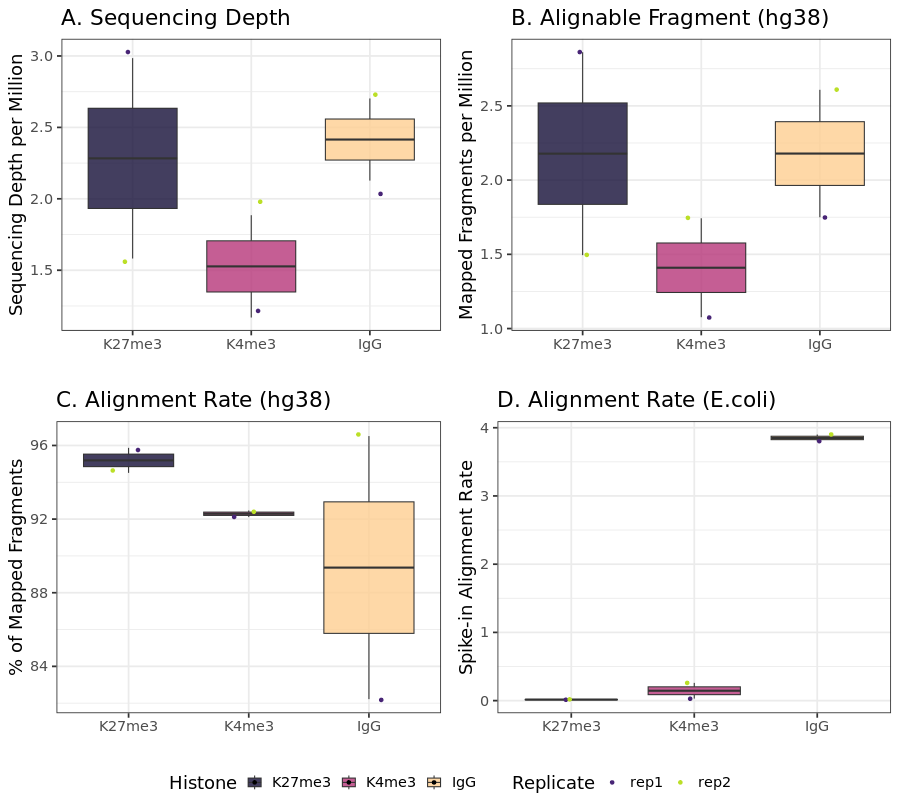

In [339]:
%%R -w 900 -h 800
print(getwd())
library(ggplot2)
library(ggpubr)

ggarrange(fig3A, fig3B, fig3C, fig3D, ncol = 2, nrow=2, common.legend = TRUE, legend="bottom") # %>% ggexport(filename = "fig3Afig3Bfig3Cfig3D.png")

## 3.3. Remove duplicates [optional/required] 
Check duplicates rate with Picard

make picard faster with `java -XX:ParallelGCThreads=<num of  threads> -jar <picard-package-name>.jar` https://www.biostars.org/p/105489/

In [ ]:
%%bash

cmd_picard_sortsam=`java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar SortSam`
cmd_picard_markduplicates=`java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar MarkDuplicates`
root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment"

for i in SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2

    mkdir -p $root_path"/"$sra"/removeDuplicate/picard_summary"

    sam_input=$root_path"/"$sra"/alignment/sam/"$id_name"_bowtie2.sam"
    sam_sorted_output=$root_path"/$sra/alignment/sam/"$id_name"_bowtie2.sorted.sam"
    sam_sorted_duplicates=$root_path"/"$sra"/alignment/sam/"$id_name"_bowtie2.sorted.dupMarked.sam"
    metrics_file_mark_duplicates=$root_path"/"$sra"/removeDuplicate/picard_summary/"$id_name"_picard.dupMark.txt"
    sam_without_duplicates_output=$root_path"/"$sra"/removeDuplicate/"$id_name"\_bowtie2.sorted.rmDup.sam"
    removed_dup_metrics_file=$root_path"/"$sra"/removeDuplicate/picard_summary/"$id_name"\_picard.rmDup.txt"


    echo "-------------------- sorting by coordinate -------------------"
    java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar SortSam -I $sam_input -O $sam_sorted_output -SORT_ORDER coordinate

    echo "-------------------- mark duplicates ----------------------" 
    java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar MarkDuplicates -I $sam_sorted_output --METRICS_FILE $metrics_file_mark_duplicates -O $sam_sorted_duplicates

    echo "-------------------- remove duplicates --------------------"
    java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar MarkDuplicates -I $sam_sorted_output -O $sam_without_duplicates_output --REMOVE_DUPLICATES true -METRICS_FILE $removed_dup_metrics_file

done

## Summarize the duplication information from the picard summary outputs.

In [103]:
%%R  

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"
sras = c('SRR12246717', 'SRR11074240', 'SRR11074254', 'SRR11074258', 'SRR11923224', 'SRR8754612')
sampleList = c("K27me3_rep1", "K27me3_rep2", "K4me3_rep1", "K4me3_rep2", "IgG_rep1", "IgG_rep2")
histList = c("K27me3", "K4me3", "IgG")
tuple_sras_sampleList = mapply(c, sras, sampleList, SIMPLIFY = FALSE)

alignResult = c()
dupResult = NULL

for(pair in tuple_sras_sampleList){
    sra = pair[1]
    hist = pair[2]
    dupRes = read.table(paste0(projPath, sra, "/removeDuplicate/picard_summary/", hist, "_picard.rmDup.txt"), header = TRUE, fill = TRUE)
    histInfo = strsplit(hist, "_")[[1]]    
    dupResult = data.frame(Histone = histInfo[1], Replicate = histInfo[2], MappedFragNum_hg38 = dupRes$READ_PAIRS_EXAMINED[1] 
                           %>% as.character %>% as.numeric, DuplicationRate = dupRes$PERCENT_DUPLICATION[1] 
                           %>% as.character %>% as.numeric * 100, EstimatedLibrarySize = dupRes$ESTIMATED_LIBRARY_SIZE[1] 
                           %>% as.character %>% as.numeric) %>% mutate(UniqueFragNum = MappedFragNum_hg38 * (1-DuplicationRate/100)) %>% rbind(dupResult, .)
}

dupResult$Histone = factor(dupResult$Histone, levels = histList)
write.csv(dupResult, "dupications_results.csv", row.names = FALSE)
dupResult

  Histone Replicate MappedFragNum_hg38 DuplicationRate EstimatedLibrarySize
1  K27me3      rep1            2861228          4.7577             29108084
2  K27me3      rep2            2607950          1.0261            126205964
3   K4me3      rep1            1494797          6.4578             11069756
4   K4me3      rep2            1743039          2.6511             32290056
5     IgG      rep1            1749402         81.0995               332366
6     IgG      rep2            1076403         39.3235               979566
  UniqueFragNum
1     2725099.4
2     2581189.8
3     1398266.0
4     1696829.3
5      330645.7
6      653123.7


In [125]:
alignSummary.insert(1, "DuplicationRate", dupResult['DuplicationRate'])
alignSummary.insert(1, "EstimatedLibrarySize", dupResult['EstimatedLibrarySize'])
alignSummary.insert(1, "EUniqueFragNum", dupResult['UniqueFragNum'])

alignSummary.to_csv("alignDupSummary.csv", index=False)

In [126]:
alignDupSummary = pd.read_csv('alignDupSummary.csv')
alignDupSummary

,Histone,EUniqueFragNum,EstimatedLibrarySize,DuplicationRate,Replicate,SequencingDepth,MappedFragNum_hg38,AlignmentRate_hg38,AlignmentRate_spikeIn,MappedFragNum_spikeIn
0,K27me3,2.725099e+06,29108084,4.7577,rep1,2984630,2861228,95.87%,0.01%,251
1,K27me3,2.581190e+06,126205964,1.0261,rep2,1581710,1494797,94.51%,0.02%,537
2,K4me3,1.398266e+06,11069756,6.4578,rep1,1168663,1076403,92.11%,0.03%,410
3,K4me3,1.696829e+06,32290056,2.6511,rep2,1885056,1743039,92.47%,0.26%,4902
4,IgG,3.306457e+05,332366,81.0995,rep1,2127635,1749402,82.22%,3.8%,80921
5,IgG,6.531237e+05,979566,39.3235,rep2,2702260,2607950,96.51%,3.9%,45628


### 3.3.generate boxplot figure for the duplication rate

In [48]:
%%R
fig4A = dupResult %>% ggplot(aes(x = Histone, y = DuplicationRate, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Duplication Rate (*100%)") +
    xlab("") 

fig4B = dupResult %>% ggplot(aes(x = Histone, y = EstimatedLibrarySize, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Estimated Library Size") +
    xlab("") 

fig4C = dupResult %>% ggplot(aes(x = Histone, y = UniqueFragNum, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("# of Unique Fragments") +
    xlab("")

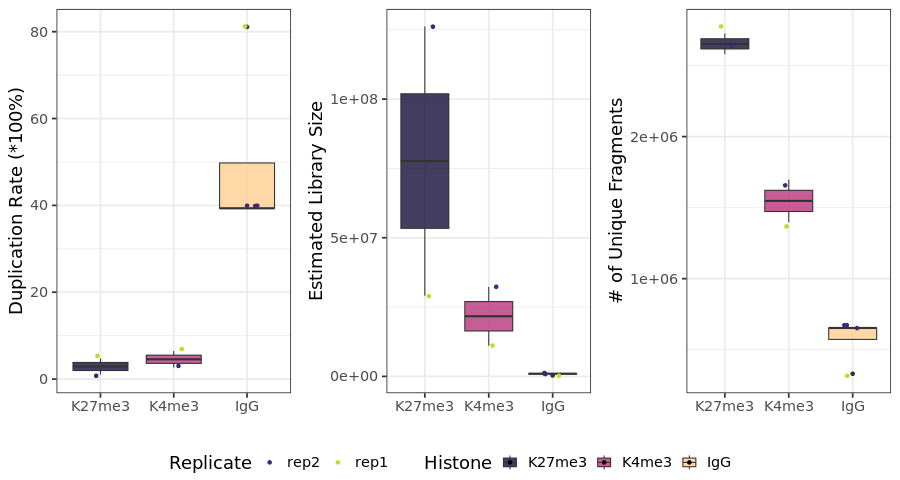

In [50]:
%%R -w 900
ggarrange(fig4A, fig4B, fig4C, ncol = 3, common.legend = TRUE, legend="bottom")

### 3.4. Assess mapped fragment size distribution [Required]

In [30]:
%%bash

root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"

# for i in SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
for i in SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    
    histName=$id_name
    
    sam_input=$root_path$sra"/alignment/sam/"$id_name"_bowtie2.sam"

    mkdir -p $root_path$sra"/alignment/sam/fragmentLen"

    ## Extract the 9th column from the alignment sam file which is the fragment length
    samtools view -F 0x04 $sam_input | \
        awk -F'\t' 'function abs(x){return ((x < 0.0) ? -x : x)} {print abs($9)}' | sort | uniq -c | \
        awk -v OFS="\t" '{print $2, $1/2}' > $root_path$sra"/alignment/sam/fragmentLen/"$id_name"_fragmentLen.txt"
done    

#### 3.5 Collect the fragment size information

In [ ]:
%%R

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"
sras = c('SRR12246717', 'SRR11074240', 'SRR11074254', 'SRR11074258', 'SRR11923224', 'SRR8754612')
sampleList = c("K27me3_rep1", "K27me3_rep2", "K4me3_rep1", "K4me3_rep2", "IgG_rep1", "IgG_rep2")
histList = c("K27me3", "K4me3", "IgG")
tuple_sras_sampleList = mapply(c, sras, sampleList, SIMPLIFY = FALSE)

fragLen = c()

for(pair in tuple_sras_sampleList){
    sra = pair[1]
    hist = pair[2]
    histInfo = strsplit(hist, "_")[[1]]
    fragLen = read.table(paste0(projPath, sra, "/alignment/sam/fragmentLen/", hist, "_fragmentLen.txt"), header = FALSE) %>% mutate(fragLen = V1 %>% as.numeric, fragCount = V2 %>% as.numeric, Weight = as.numeric(V2)/sum(as.numeric(V2)), Histone = histInfo[1], Replicate = histInfo[2], sampleInfo = hist) %>% rbind(fragLen, .) 
}

fragLen$sampleInfo = factor(fragLen$sampleInfo, levels = sampleList)
fragLen$Histone = factor(fragLen$Histone, levels = histList)
## Generate the fragment size density plot (violin plot)
fig5A = fragLen %>% ggplot(aes(x = sampleInfo, y = fragLen, weight = Weight, fill = Histone)) +
    geom_violin(bw = 5) +
    scale_y_continuous(breaks = seq(0, 800, 50)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 20) +
    ggpubr::rotate_x_text(angle = 20) +
    ylab("Fragment Length") +
    xlab("")

fig5B = fragLen %>% ggplot(aes(x = fragLen, y = fragCount, color = Histone, group = sampleInfo, linetype = Replicate)) +
  geom_line(size = 1) +
  scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma") +
  theme_bw(base_size = 20) +
  xlab("Fragment Length") +
  ylab("Count") +
  coord_cartesian(xlim = c(0, 500))

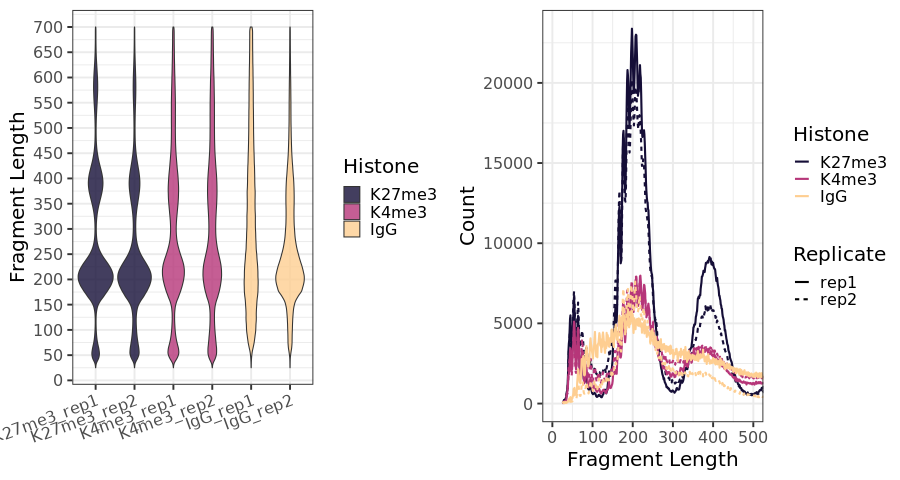

In [53]:
%%R -w 900
ggarrange(fig5A, fig5B, ncol = 2)

# 4. Alignment results filtering and file format conversion <a class="anchor" id="post_alignment"> </a>

## 4.1 Filtering mapped reads by the mapping quality filtering [optinal]

## 4.2 File format conversion [required]

In [63]:
%%bash

root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"

# for i in SRR12246717,K27me3_rep1 SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
for i in SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    
    mkdir -p $root_path$sra"/alignment/sam/"
    mkdir -p $root_path$sra"/alignment/bam/"
    mkdir -p $root_path$sra"/alignment/bed/"
    
    sam_file=$root_path$sra"/alignment/sam/"$id_name"_bowtie2.sam"
    mapped_bam=$root_path$sra"/alignment/bam/"$id_name"_bowtie2.mapped.bam"
    bed_file=$root_path$sra"/alignment/bed/"$id_name"_bowtie2.mapped.bed"
    clean_bed_file=$root_path$sra"/alignment/bed/"$id_name"_bowtie2.clean.bed"
    fragments_bed_file=$root_path$sra"/alignment/bed/"$id_name"_bowtie2.fragments.bed"
    
    echo "doing sample: " $id_name
    
    echo "Filter and keep the mapped read pairs"
    samtools view -bS -F 0x04 $sam_file >$mapped_bam

    echo "Convert into bed file format"
    bedtools bamtobed -i $mapped_bam -bedpe >$bed_file

    echo "Keep the read pairs that are on the same chromosome and fragment length less than 1000bp."
    awk '$1==$4 && $6-$2 < 1000 {print $0}' $bed_file >$clean_bed_file

    ## Only extract the fragment related columns
    cut -f 1,2,6 $clean_bed_file | sort -k1,1 -k2,2n -k3,3n  >$fragments_bed_file

done;

doing sample:  K27me3_rep2
Filter and keep the mapped read pairs
Convert into bed file format
Keep the read pairs that are on the same chromosome and fragment length less than 1000bp.
doing sample:  K4me3_rep1
Filter and keep the mapped read pairs
Convert into bed file format
Keep the read pairs that are on the same chromosome and fragment length less than 1000bp.
doing sample:  K4me3_rep2
Filter and keep the mapped read pairs
Convert into bed file format
Keep the read pairs that are on the same chromosome and fragment length less than 1000bp.
doing sample:  IgG_rep1
Filter and keep the mapped read pairs
Convert into bed file format
Keep the read pairs that are on the same chromosome and fragment length less than 1000bp.
doing sample:  IgG_rep2
Filter and keep the mapped read pairs
Convert into bed file format
Keep the read pairs that are on the same chromosome and fragment length less than 1000bp.


## 4.3 Assess replicate reproducibility

### 4.3.1 genome is split into 500 bp bins

In [64]:
%%bash

root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"

## We use the mid point of each fragment to infer which 500bp bins does this fragment belong to.
binLen=500

for i in SRR12246717,K27me3_rep1 SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    
    fragments_bed_file=$root_path$sra"/alignment/bed/"$id_name"_bowtie2.fragments.bed"
    binned_fragments_bed_file=$root_path$sra"/alignment/bed/"$id_name"_bowtie2.fragmentsCount.bin"$binLen".bed"
    
    awk -v w=$binLen '{print $1, int(($2 + $3)/(2*w))*w + w/2}' $fragments_bed_file \
        | sort -k1,1V -k2,2n | uniq -c | awk -v OFS="\t" '{print $2, $3, $1}' \
        | sort -k1,1V -k2,2n  >$binned_fragments_bed_file
done; 

In [66]:
%%R

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"
sras = c('SRR12246717', 'SRR11074240', 'SRR11074254', 'SRR11074258', 'SRR11923224', 'SRR8754612')
sampleList = c("K27me3_rep1", "K27me3_rep2", "K4me3_rep1", "K4me3_rep2", "IgG_rep1", "IgG_rep2")
histList = c("K27me3", "K4me3", "IgG")
tuple_sras_sampleList = mapply(c, sras, sampleList, SIMPLIFY = FALSE)

reprod = c()
fragCount = NULL


for(pair in tuple_sras_sampleList){
    sra = pair[1]
    hist = pair[2]

    if(is.null(fragCount)){
    
    fragCount = read.table(paste0(projPath, sra, "/alignment/bed/", hist, "_bowtie2.fragmentsCount.bin500.bed"), header = FALSE) 
    colnames(fragCount) = c("chrom", "bin", hist)
  
    }else{
    
    fragCountTmp = read.table(paste0(projPath, sra, "/alignment/bed/", hist, "_bowtie2.fragmentsCount.bin500.bed"), header = FALSE)
    colnames(fragCountTmp) = c("chrom", "bin", hist)
    fragCount = full_join(fragCount, fragCountTmp, by = c("chrom", "bin"))
    
  }
}

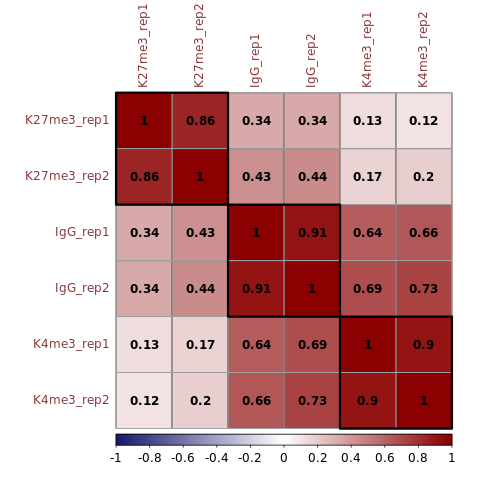

In [67]:
%%R

M = cor(fragCount %>% select(-c("chrom", "bin")) %>% log2(), use = "complete.obs") 

corrplot(M, method = "color", outline = T, addgrid.col = "darkgray", order="hclust", addrect = 3, rect.col = "black", rect.lwd = 3,cl.pos = "b", tl.col = "indianred4", tl.cex = 1, cl.cex = 1, addCoef.col = "black", number.digits = 2, number.cex = 1, col = colorRampPalette(c("midnightblue","white","darkred"))(100))

# 5. Spike-in calibration <a class="anchor" id="spikein"> </a>

### get seqdepth for each sample

In [78]:
%%bash
root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"
for i in SRR12246717,K27me3_rep1 SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    
    spikeIn_sam_file=$root_path$sra"/alignment/sam/"$id_name"_bowtie2_spikeIn.sam"
    spikeIn_seqDepth_file=$root_path$sra"/alignment/sam/bowtie2_summary/"$id_name"_bowtie2_spikeIn.seqDepth"
    
    seqDepthDouble=`samtools view -F 0x04 $spikeIn_sam_file | wc -l`
    seqDepth=$((seqDepthDouble/2))
    echo $seqDepth >$spikeIn_seqDepth_file
    
done;    

### get normalized bedgraph

In [93]:
%%bash

chromSize="/network/projects/_groups/grn_control/bow/hg38.chrom.sizes"
root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"

for i in SRR12246717,K27me3_rep1 SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    
    spikeIn_seqDepth_file=$root_path$sra"/alignment/sam/bowtie2_summary/"$id_name"_bowtie2_spikeIn.seqDepth"
    
    seqDepth=`cat $spikeIn_seqDepth_file`
    
    if [[ "$seqDepth" -gt "1" ]]; then
        
        mkdir -p $root_path$sra/alignment/bedgraph
    
        fragments_bed_file=$root_path$sra"/alignment/bed/"$id_name"_bowtie2.fragments.bed"
        norm_bedgraph=$root_path$sra"/alignment/bedgraph/"$id_name"_bowtie2.normalized.bedgraph"
    
        scale_factor=`echo "10000 / $seqDepth" | bc -l`
        echo "Scaling factor for $histName is: $scale_factor!"
        bedtools genomecov -bg -scale $scale_factor -i $fragments_bed_file -g $chromSize > $norm_bedgraph
    
    fi
done;

Scaling factor for  is: 39.84063745019920318725!
Scaling factor for  is: 18.62197392923649906890!
Scaling factor for  is: 24.39024390243902439024!
Scaling factor for  is: 2.03998368013055895552!
Scaling factor for  is: .12357731614784790103!
Scaling factor for  is: .21916367142982379240!


### 5.1 Scaling factor

In [127]:
%%R

scaleFactor = c()
multiplier = 10000

for(pair in tuple_sras_sampleList){
    sra = pair[1]
    hist = pair[2]
    spikeDepth = read.table(paste0(projPath, sra, "/alignment/sam/bowtie2_summary/", hist, "_bowtie2_spikeIn.seqDepth"), header = FALSE, fill = TRUE)$V1[1]
    histInfo = strsplit(hist, "_")[[1]]
    scaleFactor = data.frame(scaleFactor = multiplier/spikeDepth, Histone = histInfo[1], Replicate = histInfo[2])  %>% rbind(scaleFactor, .)
}
scaleFactor$Histone = factor(scaleFactor$Histone, levels = histList)
write.csv(scaleFactor, "scaleFactor.csv", row.names = FALSE)

alignDupSummary = read.csv(file='alignDupSummary.csv')
left_join(alignDupSummary, scaleFactor, by = c("Histone", "Replicate"))

  Histone EUniqueFragNum EstimatedLibrarySize DuplicationRate Replicate
1  K27me3      2725099.4             29108084          4.7577      rep1
2  K27me3      2581189.8            126205964          1.0261      rep2
3   K4me3      1398266.0             11069756          6.4578      rep1
4   K4me3      1696829.3             32290056          2.6511      rep2
5     IgG       330645.7               332366         81.0995      rep1
6     IgG       653123.7               979566         39.3235      rep2
  SequencingDepth MappedFragNum_hg38 AlignmentRate_hg38 AlignmentRate_spikeIn
1         2984630            2861228             95.87%                 0.01%
2         1581710            1494797             94.51%                 0.02%
3         1168663            1076403             92.11%                 0.03%
4         1885056            1743039             92.47%                 0.26%
5         2127635            1749402             82.22%                  3.8%
6         2702260           

In [131]:
%%R

# Generate sequencing depth boxplot

fig6A = scaleFactor %>% ggplot(aes(x = Histone, y = scaleFactor, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 20) +
    ylab("Spike-in Scalling Factor") +
    xlab("")

In [140]:
%%R
alignResult=read.csv(file='alignResult.csv')
alignResult
normDepth = inner_join(scaleFactor, alignResult, by = c("Histone", "Replicate")) %>% mutate(normDepth = MappedFragNum_hg38 * scaleFactor)
write.csv(normDepth, "normDepth.csv", row.names = FALSE)
normDepth

  scaleFactor Histone Replicate SequencingDepth MappedFragNum_hg38
1  39.8406375  K27me3      rep1         2984630            2861228
2  18.6219739  K27me3      rep2         1581710            1494797
3  24.3902439   K4me3      rep1         1168663            1076403
4   2.0399837   K4me3      rep2         1885056            1743039
5   0.1235773     IgG      rep1         2127635            1749402
6   0.2191637     IgG      rep2         2702260            2607950
  AlignmentRate_hg38   normDepth
1             95.87% 113993147.4
2             94.51%  27836070.8
3             92.11%  26253731.7
4             92.47%   3555771.1
5             82.22%    216186.4
6             96.51%    571567.9


In [142]:
%%R
fig6B = normDepth %>% ggplot(aes(x = Histone, y = normDepth, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 20) +
    ylab("Normalization Fragment Count") +
    xlab("") + 
    coord_cartesian(ylim = c(1000000, 130000000))
    

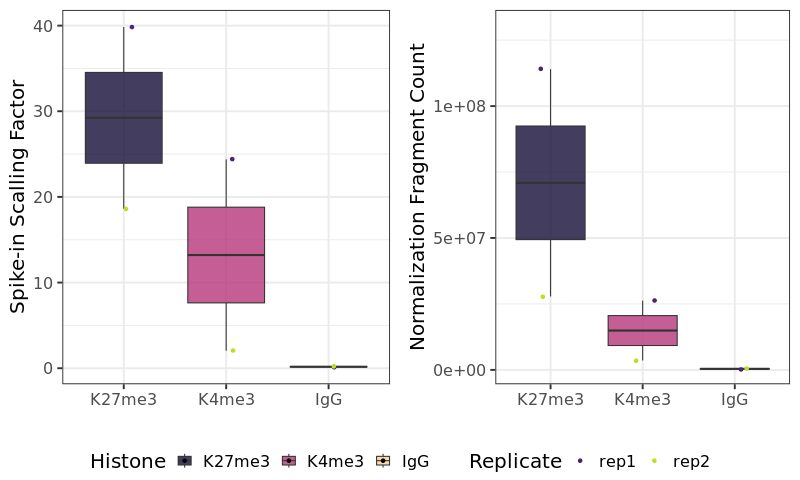

In [145]:
%%R -w 800
ggarrange(fig6A, fig6B, ncol = 2, common.legend = TRUE, legend="bottom")

# 6. Peak Calling <a class="anchor" id="peak_calling"> </a>

## 6.1. SEACR

In [168]:
%%bash
seacr="/network/projects/_groups/grn_control/bow/programs/SEACR_1.3.sh"
dir_peak_calling="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/peakCalling/SEACR/"

root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"

for i in SRR12246717,K27me3_rep1 SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2 SRR11923224,IgG_rep1 SRR8754612,IgG_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    mkdir -p $dir_peak_calling$sra
    
    norm_bedgraph=$root_path$sra"/alignment/bedgraph/"$id_name"_bowtie2.normalized.bedgraph"
    control_bedgraph=$root_path"SRR11923224/alignment/bedgraph/IgG_rep1_bowtie2.normalized.bedgraph"

    control_peaks_file=$dir_peak_calling$sra"/"$id_name"_seacr_control.peaks"
    top0_01_peaks=$dir_peak_calling$sra"/"$id_name"_seacr_top0.01.peaks"
    
    bash $seacr $norm_bedgraph $control_bedgraph non stringent $control_peaks_file

    bash $seacr $norm_bedgraph 0.01 non stringent $top0_01_peaks

done;

Calling enriched regions with control file
Proceeding without normalization of control to experimental bedgraph
Using stringent threshold
Creating experimental AUC file: Thu Dec  1 04:22:40 EST 2022
Creating control AUC file: Thu Dec  1 04:22:51 EST 2022
Calculating optimal AUC threshold: Thu Dec  1 04:22:52 EST 2022
Calculating threshold using non-normalized control: Thu Dec  1 04:22:52 EST 2022
Creating thresholded feature file: Thu Dec  1 04:23:02 EST 2022
Empirical false discovery rate = 2.4668313961862e-05
Merging nearby features and eliminating control-enriched features: Thu Dec  1 04:23:03 EST 2022
Removing temporary files: Thu Dec  1 04:23:04 EST 2022
Done: Thu Dec  1 04:23:04 EST 2022
Calling enriched regions without control file
Proceeding without normalization of control to experimental bedgraph
Using stringent threshold
Creating experimental AUC file: Thu Dec  1 04:23:04 EST 2022
Calculating optimal AUC threshold: Thu Dec  1 04:23:15 EST 2022
Using user-provided threshold: 

Error in quantile.default(frame$diff, test3) : 'probs' outside [0,1]
Calls: quantile -> quantile.default
Execution halted


### 6.1.1 Number of peaks called

In [92]:
%%R

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/tutorial/"
sras = c('SRR12246717', 'SRR11074240', 'SRR11074254', 'SRR11074258', 'SRR11923224', 'SRR8754612')
sampleList = c("K27me3_rep1", "K27me3_rep2", "K4me3_rep1", "K4me3_rep2", "IgG_rep1", "IgG_rep2")
histList = c("K27me3", "K4me3", "IgG")
tuple_sras_sampleList = mapply(c, sras, sampleList, SIMPLIFY = FALSE)

peakN = c()
peakWidth = c()
peakType = c("control", "top0.01")

for(pair in tuple_sras_sampleList){
    sra = pair[1]
    hist = pair[2]

    histInfo = strsplit(hist, "_")[[1]]
    if(histInfo[1] != "IgG"){
    for(type in peakType){
      peakInfo = read.table(paste0(projPath, "peakCalling/SEACR/", sra, "/", hist, "_seacr_", type, ".peaks.stringent.bed"), header = FALSE, fill = TRUE)  %>% mutate(width = abs(V3-V2))
      peakN = data.frame(peakN = nrow(peakInfo), peakType = type, Histone = histInfo[1], Replicate = histInfo[2]) %>% rbind(peakN, .)
      peakWidth = data.frame(width = peakInfo$width, peakType = type, Histone = histInfo[1], Replicate = histInfo[2])  %>% rbind(peakWidth, .)
    }
  }
}
peakN = peakN %>% select(Histone, Replicate, peakType, peakN)
write.csv(peakN, "peakN.csv", row.names = FALSE)
peakN

  Histone Replicate peakType  peakN
1  K27me3      rep1  control 190909
2  K27me3      rep1  top0.01   6005
3  K27me3      rep2  control 113108
4  K27me3      rep2  top0.01   9797
5   K4me3      rep1  control   4942
6   K4me3      rep1  top0.01    903
7   K4me3      rep2  control   8139
8   K4me3      rep2  top0.01   3764


### 6.1.2 Reproducibility of the peak across biological replicates

In [96]:
%%R

library(hash)
h <- hash() 
h[["K27me3_rep1"]] = "SRR12246717"
h[["K27me3_rep2"]] = 'SRR11074240'
h[["K4me3_rep1"]] = 'SRR11074254'
h[["K4me3_rep2"]] = 'SRR11074258'

histL = c("K27me3", "K4me3")
repL = paste0("rep", 1:2)
peakType = c("control", "top0.01")
peakOverlap = c()
  
for(type in peakType){
  for(hist in histL){
    overlap.gr = GRanges()
    for(rep in repL){
        
      x <- c(hist, "_", rep)
      full = paste(x, collapse="")
      sra = h[[full]]
         
      peakInfo = read.table(paste0(projPath, "/peakCalling/SEACR/", sra, "/", hist, "_", rep, "_seacr_", type, ".peaks.stringent.bed"), header = FALSE, fill = TRUE)
      peakInfo.gr = GRanges(peakInfo$V1, IRanges(start = peakInfo$V2, end = peakInfo$V3), strand = "*")
      
      if(length(overlap.gr) >0){
        overlap.gr = overlap.gr[findOverlaps(overlap.gr, peakInfo.gr)@from]
      }else{
        overlap.gr = peakInfo.gr
        
      }
    }
    peakOverlap = data.frame(peakReprod = length(overlap.gr), Histone = hist, peakType = type) %>% rbind(peakOverlap, .)
  }
}

peakReprod = left_join(peakN, peakOverlap, by = c("Histone", "peakType")) %>% mutate(peakReprodRate = peakReprod/peakN * 100)
peakReprod = peakReprod %>% select(Histone, Replicate, peakType, peakN, peakReprodNum = peakReprod, peakReprodRate)
write.csv(peakReprod, "peakReprod.csv", row.names = FALSE)
peakReprod

  Histone Replicate peakType  peakN peakReprodNum peakReprodRate
1  K27me3      rep1  control 190909        104046       54.50031
2  K27me3      rep1  top0.01   6005          5383       89.64197
3  K27me3      rep2  control 113108        104046       91.98819
4  K27me3      rep2  top0.01   9797          5383       54.94539
5   K4me3      rep1  control   4942          4940       99.95953
6   K4me3      rep1  top0.01    903           898       99.44629
7   K4me3      rep2  control   8139          4940       60.69542
8   K4me3      rep2  top0.01   3764           898       23.85760


### 6.1.3 FRagment proportion in Peaks regions (FRiPs).

In [122]:
%%R

# this cell code was adapted from https://github.com/GreenleafLab/chromVAR/blob/0f27fcc8463d537d770f164a55f949701beb6add/R/get_inputs.R for eay use on a cluster
library(Rsamtools)
library(SummarizedExperiment)

getCounts <- function(alignment_files, peaks, paired, by_rg = FALSE, 
                       format = c("bam", "bed"), colData = NULL) {
  
  format <- match.arg(format)
  if (format == "bam") {
    return(get_counts_from_bams(alignment_files, peaks, paired, by_rg, colData))
  } else {
    return(get_counts_from_beds(alignment_files, peaks, paired, colData))
  }
}

get_counts_from_bams <- function(bams, peaks, paired, by_rg = FALSE,
                                 sample_annotation = NULL) {
  
  if (by_rg) {
    tmp <- lapply(bams, getFragmentCountsByRG, peaks = peaks, paired = paired)
    if (!is.null(sample_annotation) && nrow(sample_annotation) == length(bams)){
      sample_annotation <- as(sample_annotation, "DataFrame")
      l <- vapply(tmp, function(x) length(x$depths), 0)
      sample_annotation <- 
        do.call(rbind, 
                lapply(seq_along(l), 
                       function(x){
                         rep(sample_annotation[x, ,drop = FALSE], l[x])}))
    }
    counts_mat <- do.call(cbind, lapply(tmp, function(x) x$counts))
    depths <- do.call(c, lapply(tmp, function(x) x$depths))
  } else {
    mat <- matrix(nrow = length(peaks), ncol = length(bams))
    depths <- vector("numeric", length(bams))
    
    for (i in seq_along(bams)) {
      message("Reading in file: ", bams[i])
      fragments <- bamToFragments(bams[i], paired = paired)
      depths[i] <- length(fragments)
      mat[, i] <- countOverlaps(peaks, fragments, type = "any", 
                                ignore.strand = TRUE)
    }
    colnames(mat) <- basename(bams)
    counts_mat <- Matrix::Matrix(mat)
  }
  if (is.null(sample_annotation)) {
    sample_annotation <- DataFrame(depth = depths)
  } else {
    sample_annotation$depth <- depths
  }
  out <- SummarizedExperiment(assays = list(counts = counts_mat), 
                              rowRanges = peaks, 
                              colData = sample_annotation)
  return(out)
}

bamToFragments <- function(bamfile, paired) {
  if (paired) {
    scanned <- scanBam(bamfile, 
                       param = 
                         ScanBamParam(flag = 
                                        scanBamFlag(isMinusStrand = FALSE, 
                                                    isProperPair = TRUE),
                                      what = c("rname", "pos", "isize")))[[1]]
    scanned_left <- GRanges(seqnames = scanned$rname, 
                            IRanges(start = scanned$pos, 
                                    width = 1), strand = "+")
    scanned_right <- GRanges(seqnames = scanned$rname, 
                             IRanges(start = scanned$pos + 
                                       abs(scanned$isize) - 1, width = 1),
                             strand = "-")
    out <- left_right_to_grglist(scanned_left, scanned_right)
  } else {
    scanned <- scanBam(bamfile,
                       param = ScanBamParam(what = c("rname", 
                                                     "pos", 
                                                     "strand", 
                                                     "qwidth")))[[1]]
    out <- GRanges(seqnames = scanned$rname, 
                   IRanges(start = ifelse(scanned$strand == "-", 
                                          scanned$pos + scanned$qwidth - 1, 
                                          scanned$pos),
                           width = 1))
  }
  return(out)
  
}

left_right_to_grglist <- function(left, right) {
  stopifnot(length(left) == length(right))
  if (length(left) == 0) {
    return(GenomicRangesList())
  }
  x <- c(left, right)[as.vector(matrix(seq_len(2L * length(left)), nrow = 2L, 
                                       byrow = TRUE))]
  p <- PartitioningByEnd(cumsum(rep(2, length(x)/2)))
  out <- relist(x, p)
  return(out)
}

setMethod("counts", signature(object = "SummarizedExperiment"), 
          function(object) {
  stopifnot("counts" %in% assayNames(object))
  assays(object)$counts
})


#' @rdname counts
#' @param value matrix of counts
#' @aliases counts<-,SummarizedExperiment-method
#' @importMethodsFrom BiocGenerics counts<-
#' @exportMethod 'counts<-'
setReplaceMethod("counts", signature(object = "SummarizedExperiment", 
                                     value = "MatrixOrmatrix"), 
                 function(object, value) {
                   assays(object)[["counts"]] <- value
                   validObject(object)
                   object
                 })

R[write to console]: in method for ‘counts<-’ with signature ‘object="SummarizedExperiment",value="MatrixOrmatrix"’: no definition for class “MatrixOrmatrix”



In [165]:
%%R

# library(chromVAR)
# register(MulticoreParam(32))

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/tutorial/"

library(hash)
h <- hash() 
h[["K27me3_rep1"]] = "SRR12246717"
h[["K27me3_rep2"]] = 'SRR11074240'
h[["K4me3_rep1"]] = 'SRR11074254'
h[["K4me3_rep2"]] = 'SRR11074258'

histL = c("K27me3", "K4me3")
repL = paste0("rep", 1:2)


inPeakData = c()

## overlap with bam file to get count
for(hist in histL){
    for(rep in repL){
        
        x <- c(hist, "_", rep)
        full_sample_name = paste(x, collapse="")
        sra = h[[full_sample_name]]
        
        peakRes = read.table(paste0(projPath, "/peakCalling/SEACR/", sra, "/", hist, "_", rep, "_seacr_control.peaks.stringent.bed"), header = FALSE, fill = TRUE)
        peak.gr = GRanges(seqnames = peakRes$V1, IRanges(start = peakRes$V2, end = peakRes$V3), strand = "*")
        bamDir = paste0(projPath, "alignment/", sra, "/alignment/bam")
        bamFile = paste0(bamDir, "/", hist, "_", rep, "_bowtie2.mapped.bam")
        
        fragment_counts <- getCounts(bamFile, peak.gr, paired = TRUE, by_rg = FALSE, format = "bam")
        inPeakN = counts(fragment_counts)[,1] %>% sum
        
        inPeakData = rbind(inPeakData, data.frame(inPeakN = inPeakN, Histone = hist, Replicate = rep))
        
      }
    
}

frip = left_join(inPeakData, alignResult, by = c("Histone", "Replicate")) %>% mutate(frip = inPeakN/MappedFragNum_hg38 * 100) # this is what the tutorial plots! not the one below!
# frip %>% select(Histone, Replicate, SequencingDepth, MappedFragNum_hg38, AlignmentRate_hg38, FragInPeakNum = inPeakN, FRiPs = frip)

write.csv(frip, "frip.csv", row.names = FALSE)
frip

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR12246717/alignment/bam/K27me3_rep1_bowtie2.mapped.bam

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR11074240/alignment/bam/K27me3_rep2_bowtie2.mapped.bam

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR11074254/alignment/bam/K4me3_rep1_bowtie2.mapped.bam

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR11074258/alignment/bam/K4me3_rep2_bowtie2.mapped.bam



  Histone Replicate SequencingDepth MappedFragNum_hg38 AlignmentRate_hg38
1  K27me3      rep1         2984630            2861228             95.87%
2  K27me3      rep2         1581710            1494797             94.51%
3   K4me3      rep1         1168663            1076403             92.11%
4   K4me3      rep2         1885056            1743039             92.47%
  FragInPeakNum     FRiPs
1       2317158  80.98474
2       1232588  82.45855
3       1162570 108.00509
4       1225045  70.28213


In [130]:
import pandas as pd
pd.read_csv("frip.csv")

,Histone,Replicate,SequencingDepth,MappedFragNum_hg38,AlignmentRate_hg38,FragInPeakNum,FRiPs
0,K27me3,rep1,2984630,2861228,95.87%,2317158,80.984738
1,K27me3,rep2,1581710,1494797,94.51%,1232588,82.458555
2,K4me3,rep1,1168663,1076403,92.11%,1162570,108.005087
3,K4me3,rep2,1885056,1743039,92.47%,1225045,70.282134


### 6.1.4 Visualization of peak number, peak width, peak reproducibility and FRiPs.

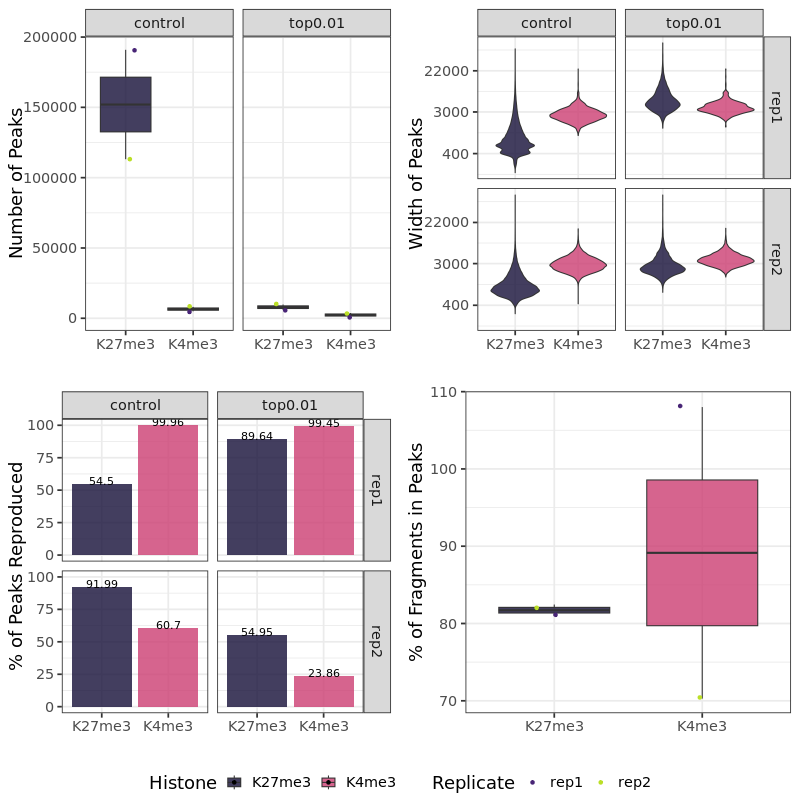

In [173]:
%%R -w 800 -h 800

fig7A = peakN %>% ggplot(aes(x = Histone, y = peakN, fill = Histone)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    facet_grid(~peakType) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.55, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Number of Peaks") +
    xlab("")

fig7B = peakWidth %>% ggplot(aes(x = Histone, y = width, fill = Histone)) +
    geom_violin() +
    facet_grid(Replicate~peakType) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.55, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    scale_y_continuous(trans = "log", breaks = c(400, 3000, 22000)) +
    theme_bw(base_size = 18) +
    ylab("Width of Peaks") +
    xlab("")

fig7C = peakReprod %>% ggplot(aes(x = Histone, y = peakReprodRate, fill = Histone, label = round(peakReprodRate, 2))) +
    geom_bar(stat = "identity") +
    geom_text(vjust = 0.1) +
    facet_grid(Replicate~peakType) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.55, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("% of Peaks Reproduced") +
    xlab("")

fig7D = frip %>% ggplot(aes(x = Histone, y = frip, fill = Histone, label = round(frip, 2))) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.55, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("% of Fragments in Peaks") +
    xlab("")

ggarrange(fig7A, fig7B, fig7C, fig7D, ncol = 2, nrow=2, common.legend = TRUE, legend="bottom")

# 7. Visualization of peaks <a class="anchor" id="igv"> </a>

## 7.1. Browser display of **normalized bedgraph files**

In [ ]:
# you can also visualize IGV directly in this notebook
from IPython.display import IFrame
url = 'https://igv.org/app/'
IFrame(url, width=1200, height=400)

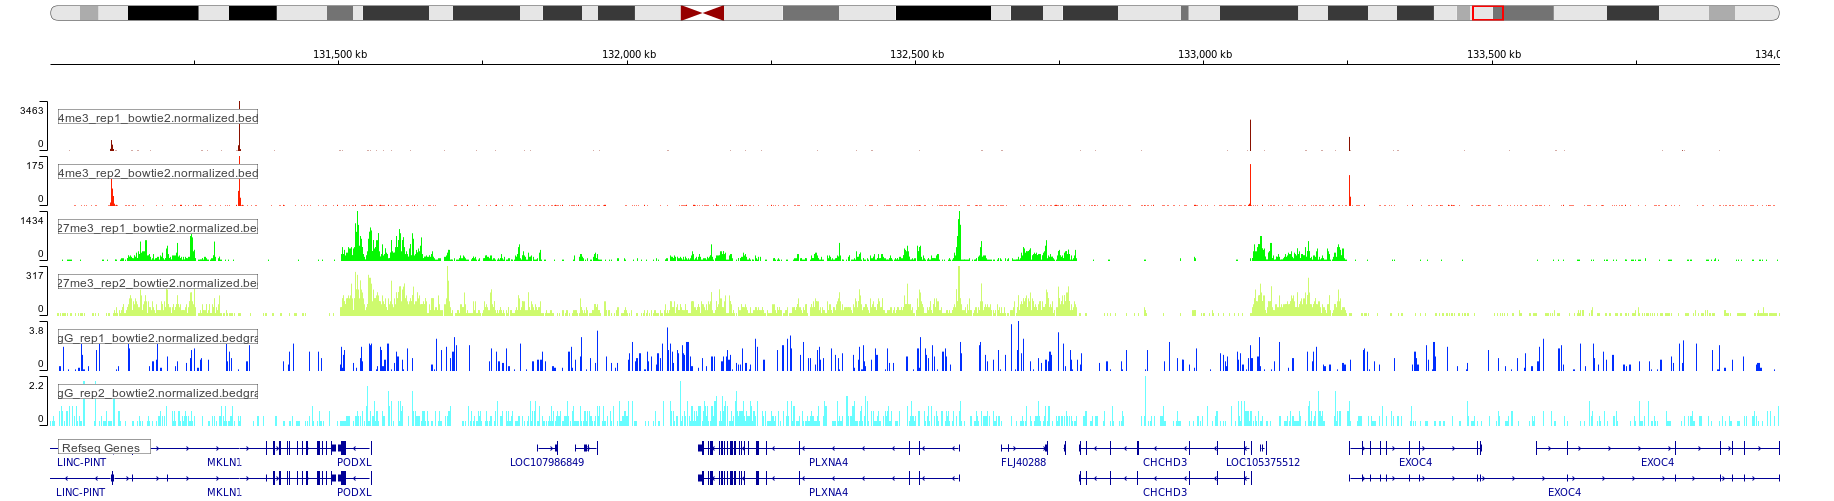

## 7.2. Heatmap visualization on specific regions

get `bamCoverag` and `computeMatrix` cmds installing deeptools: https://deeptools.readthedocs.io/en/develop/content/tools/computeMatrix.html

In [246]:
%%bash

root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"
cores=32

for i in SRR12246717,K27me3_rep1 SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    
    mkdir -p $root_path$sra"/alignment/bigwig/"
    
    mapped_bam=$root_path$sra"/alignment/bam/"$id_name"_bowtie2.mapped.bam"                                                      
    sorted_bam_output=$root_path$sra"/alignment/bam/"$id_name".sorted.bam"
    bigwig_file_output=$root_path$sra"/alignment/bigwig/"$id_name"_raw.bw"          
    
    samtools sort -o $sorted_bam_output $mapped_bam                                                     
    samtools index $sorted_bam_output                                                                                                             
    bamCoverage -b $sorted_bam_output -o $bigwig_file_output --numberOfProcessors $cores 
    
done    

bamFilesList: ['/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR12246717/alignment/bam/K27me3_rep1.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000
bamFilesList: ['/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR11074240/alignment/bam/K27me3_rep2.sorted.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None


### 7.2.1 Heatmap over transcription units

In [ ]:
%%bash

projPath="/network/projects/_groups/grn_control/bow/NanoTag/tutorial"
hg38_gene_tsv="/network/projects/_groups/grn_control/bow/hg38.refGene.gtf"
matrix_gene=$projPath"/matrix_gene.mat.gz"

cores=32
computeMatrix scale-regions -S $projPath/alignment/SRR12246717/alignment/bigwig/K27me3_rep1_raw.bw \
                               $projPath/alignment/SRR11074240/alignment/bigwig/K27me3_rep2_raw.bw \
                               $projPath/alignment/SRR11074254/alignment/bigwig/K4me3_rep1_raw.bw \
                               $projPath/alignment/SRR11074258/alignment/bigwig/K4me3_rep2_raw.bw \
                              -R $hg38_gene_tsv \
                              --beforeRegionStartLength 3000 \
                              --regionBodyLength 5000 \
                              --afterRegionStartLength 3000 \
                              --skipZeros -o $matrix_gene -p $cores

In [11]:
%%bash

projPath="/network/projects/_groups/grn_control/bow/NanoTag/tutorial"
hg38_gene_tsv="/network/projects/_groups/grn_control/bow/hg38_gene.tsv"
matrix_gene=$projPath"/matrix_gene.mat.gz"
heatmap_png=$projPath"/Histone_gene.png"

plotHeatmap -m $matrix_gene -out $heatmap_png --sortUsing sum

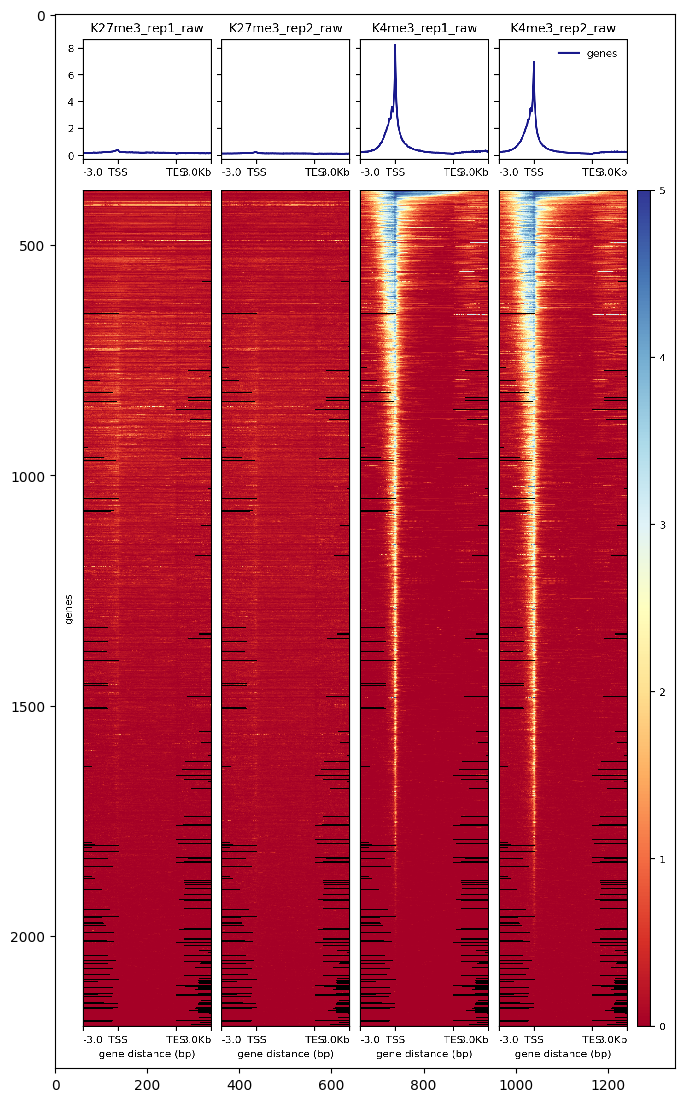

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, ))
img = plt.imread("/network/projects/_groups/grn_control/bow/NanoTag/tutorial/Histone_gene.png")
ax.imshow(img, interpolation='nearest')
plt.show()

### 7.2.2. Heatmap on CUT&Tag peaks

In [44]:
%%bash

root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/peakCalling/SEACR/"
cores=32

for i in SRR12246717,K27me3_rep1 SRR11074240,K27me3_rep2 SRR11074254,K4me3_rep1 SRR11074258,K4me3_rep2; do
    IFS=","; set -- $i;
    sra=$1
    id_name=$2
    
    peaks_summitRegion_bed=$root_path"/"$sra"/"$id_name"_seacr_control.peaks.summitRegion.bed"
    bigwig_file="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/"$sra"/alignment/bigwig/"$id_name"_raw.bw"
    output_seacr_mat=$root_path"/"$sra"/"$id_name"_SEACR.mat.gz"
    png_heatmap=$root_path"/"$sra"/"$id_name"_SEACR_heatmap.png"
    
    awk '{split($6, summit, ":"); split(summit[2], region, "-"); print summit[1]"\t"region[1]"\t"region[2]}' \
        $root_path"/"$sra"/"$id_name"_seacr_control.peaks.stringent.bed" >$peaks_summitRegion_bed

    computeMatrix reference-point -S $bigwig_file -R $peaks_summitRegion_bed \
               --skipZeros -o $output_seacr_mat -p $cores -a 3000 -b 3000 --referencePoint center

    plotHeatmap -m $output_seacr_mat -out $png_heatmap --sortUsing sum --startLabel "Peak Start" \
        --endLabel "Peak End" --xAxisLabel "" --regionsLabel "Peaks" --samplesLabel "${histName} ${repName}"
    
done    

/network/projects/_groups/grn_control/bow/NanoTag/tutorial/peakCalling/SEACR/SRR12246717/K27me3_rep1_SEACR_heatmap.png True
/network/projects/_groups/grn_control/bow/NanoTag/tutorial/peakCalling/SEACR/SRR11074240/K27me3_rep2_SEACR_heatmap.png True
/network/projects/_groups/grn_control/bow/NanoTag/tutorial/peakCalling/SEACR/SRR11074254/K4me3_rep1_SEACR_heatmap.png True
/network/projects/_groups/grn_control/bow/NanoTag/tutorial/peakCalling/SEACR/SRR11074258/K4me3_rep2_SEACR_heatmap.png True


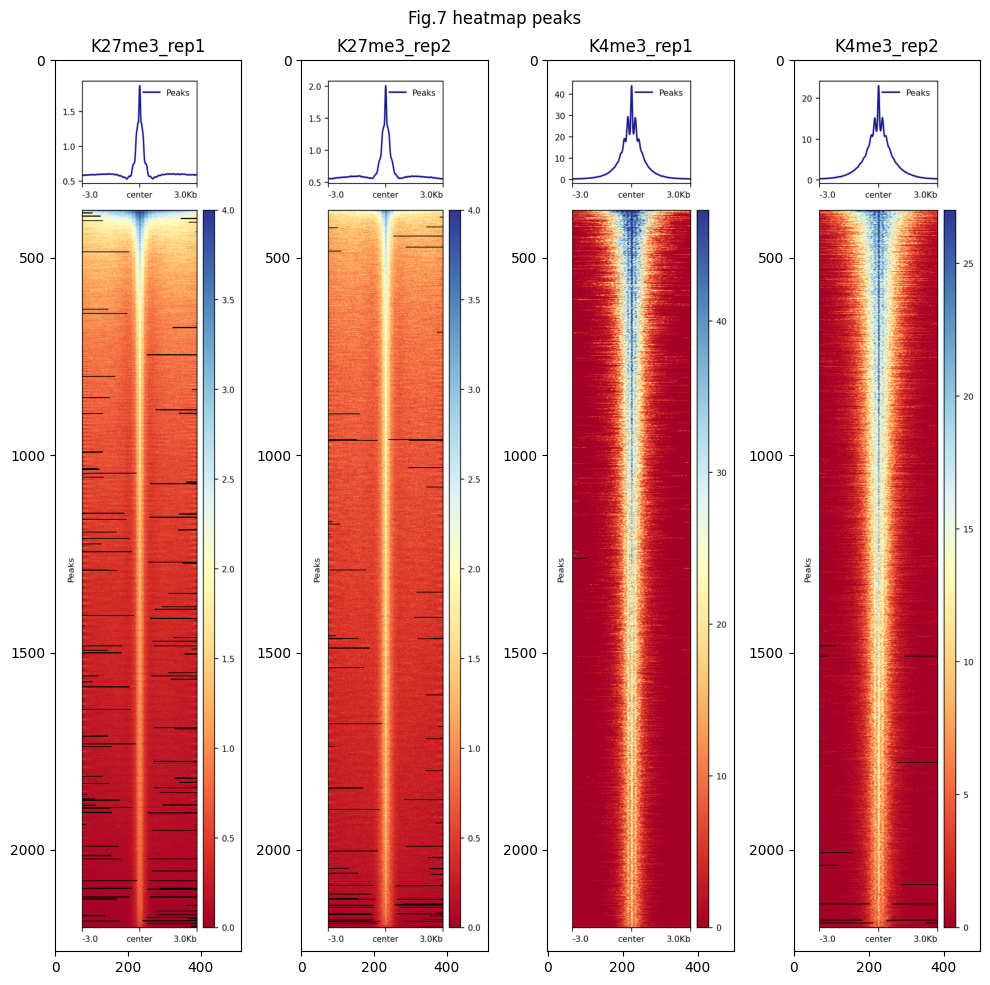

In [76]:
import os
import matplotlib

mapping_sra_to_id_name = {
    'SRR12246717' : 'K27me3_rep1',
    'SRR11074240' : 'K27me3_rep2',
    'SRR11074254' : 'K4me3_rep1',
    'SRR11074258' : 'K4me3_rep2'}

root_path="/network/projects/_groups/grn_control/bow/NanoTag/tutorial/peakCalling/SEACR"

fig, ax = plt.subplots(1, 4, figsize=(10, 10))

for plot_idx, (sra, hist) in enumerate(mapping_sra_to_id_name.items()):
    png_filepath = f"{root_path}/{sra}/{hist}_SEACR_heatmap.png"
    print(png_filepath, os.path.exists(png_filepath))
    img = plt.imread(png_filepath)
    ax[plot_idx].imshow(img, aspect="auto") # , interpolation='nearest')
    ax[plot_idx].set_title(hist)

fig.suptitle("Fig.7 heatmap peaks")  
fig.tight_layout()
fig.savefig("/network/projects/_groups/grn_control/bow/NanoTag/tutorial/heatmap_peaks_figure_7.2.2.png") 
plt.show()

# 8. Differential analysis <a class="anchor" id="diff_analysis"> </a>

### 8.1. Create the peak x sample matrix

### 8.1.1 Create a master peak list merging all the peaks called for each sample

In [88]:
%%R

library(hash)

projPath="/network/projects/_groups/grn_control/bow/NanoTag/tutorial"

h <- hash() 
h[["K27me3_rep1"]] = "SRR12246717"
h[["K27me3_rep2"]] = 'SRR11074240'
h[["K4me3_rep1"]] = 'SRR11074254'
h[["K4me3_rep2"]] = 'SRR11074258'

histL = c("K27me3", "K4me3")
repL = paste0("rep", 1:2)


mPeak = GRanges()
## overlap with bam file to get count
for(hist in histL){
  for(rep in repL){
    x <- c(hist, "_", rep)
    full_sample_name = paste(x, collapse="")
    sra = h[[full_sample_name]] 
    path = paste0(projPath, "/peakCalling/SEACR/", sra, "/", hist, "_", rep, "_seacr_control.peaks.stringent.bed")
    peakRes = read.table(path, header = FALSE, fill = TRUE)
    mPeak = GRanges(seqnames = peakRes$V1, IRanges(start = peakRes$V2, end = peakRes$V3), strand = "*") %>% append(mPeak, .)
  }
}
masterPeak = reduce(mPeak)
masterPeak

GRanges object with 207731 ranges and 0 metadata columns:
                          seqnames        ranges strand
                             <Rle>     <IRanges>  <Rle>
       [1]                    chr1   27805-30656      *
       [2]                    chr1 135727-140083      *
       [3]                    chr1 198335-200968      *
       [4]                    chr1 391014-392146      *
       [5]                    chr1 392617-393317      *
       ...                     ...           ...    ...
  [207727]        chrUn_KI270754v1   31281-40176      *
  [207728]    chr12_GL877876v1_alt 400042-403629      *
  [207729] chr14_KI270726v1_random   12706-15648      *
  [207730]     chr2_GL383522v1_alt   75744-77537      *
  [207731]    chr21_GL383581v2_alt   82150-84964      *
  -------
  seqinfo: 282 sequences from an unspecified genome; no seqlengths


### 8.1.2 Get the fragment counts for each peak in the master peak list

In [175]:
%%R

projPath="/network/projects/_groups/grn_control/bow/NanoTag/tutorial"
countMat = matrix(NA, length(masterPeak), length(histL)*length(repL))
## overlap with bam file to get count
i = 1
for(hist in histL){
  for(rep in repL){
    
    x <- c(hist, "_", rep)
    full_sample_name = paste(x, collapse="")
    sra = h[[full_sample_name]] 
    bamDir = paste0(projPath, "/alignment/", sra, "/alignment/bam/")
    bamFile = paste0(bamDir, "/", hist, "_", rep, "_bowtie2.mapped.bam")
    
    fragment_counts <- getCounts(bamFile, masterPeak, paired = TRUE, by_rg = FALSE, format = "bam")
    countMat[, i] = counts(fragment_counts)[,1]
    i = i + 1
  }
}
colnames(countMat) = paste(rep(histL, 2), rep(repL, each = 2), sep = "_")
write.csv(countMat, "countMat.csv", row.names = FALSE)

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR12246717/alignment/bam/K27me3_rep1_bowtie2.mapped.bam

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR11074240/alignment/bam/K27me3_rep2_bowtie2.mapped.bam

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR11074254/alignment/bam/K4me3_rep1_bowtie2.mapped.bam

R[write to console]: Reading in file: /network/projects/_groups/grn_control/bow/NanoTag/tutorial/alignment/SRR11074258/alignment/bam/K4me3_rep2_bowtie2.mapped.bam



## 8.2. Sequencing depth normalization and differential enriched peaks detection

In [14]:
%%R

library(DESeq2)

countMat = read.csv('countMat.csv')
histL = c("K27me3", "K4me3")
repL = paste0("rep", 1:2)

selectR = which(rowSums(countMat) > 5) ## remove low count genes
dataS = countMat[selectR,]
condition = factor(rep(histL, each = length(repL)))
dds = DESeqDataSetFromMatrix(countData = dataS,
                              colData = DataFrame(condition),
                              design = ~ condition)
DDS = DESeq(dds)
normDDS = counts(DDS, normalized = TRUE) ## normalization with respect to the sequencing depth
colnames(normDDS) = paste0(colnames(normDDS), "_norm")
res = results(DDS, independentFiltering = FALSE, altHypothesis = "greaterAbs")

countMatDiff = cbind(dataS, normDDS, res)

write.csv(countMatDiff, "countMatDiff.csv", row.names = FALSE)
head(countMatDiff)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



   K27me3_rep1 K4me3_rep1 K27me3_rep2 K4me3_rep2 K27me3_rep1_norm
1            0          0         233        186        0.0000000
2            0          2         166         89        0.0000000
3            0          0         219        169        0.0000000
7            4          2           0          1        0.9936518
9            7          2           0          0        1.7388907
10           3          5           0          0        0.7452389
   K4me3_rep1_norm K27me3_rep2_norm K4me3_rep2_norm    baseMean log2FoldChange
1        0.0000000         935.1271      544.608956 369.9340164     13.8143519
2        0.6260696         666.2279      260.592457 231.8616062     10.6735778
3        0.0000000         878.9392      494.832869 343.4430208     13.7069526
7        0.6260696           0.0000        2.928005   1.1369316      1.0340087
9        0.6260696           0.0000        0.000000   0.5912401     -0.9125533
10       1.5651740           0.0000        0.000000   0.5776032 

In [ ]:
import pandas as pd
pd.read_csv("countMatDiff.csv")